In [2]:
import PyComplexHeatmap as pch
import pandas as pd
from pathlib import Path
import re
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import muon as mu

2024-03-03 16:46:27.047155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 16:46:28.163197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [131]:
import cellrank as cr

In [170]:
cr.settings.figdir="../result/24.2.4_fig3_pathway/"

In [4]:
clusterGene= pd.read_csv("../result/6.21_traj_hm/12.26_symbolOrderCluster.csv",index_col=0)

In [5]:
coorDf=pd.read_csv("../processed_data/24.1.16_lineageDotHeatmap/1.16_pearson.csv",index_col=0)
peakDf=pd.read_csv("../processed_data/24.1.16_lineageDotHeatmap/1.16_max.csv",index_col=0)
exprDf=pd.read_csv("../processed_data/24.1.16_lineageDotHeatmap/1.16_sum.csv",index_col=0)

In [6]:
coorDf_sqrt = np.where(coorDf >= 0, np.sqrt(coorDf), -np.sqrt(-coorDf))
coorDf_sqrt=pd.DataFrame(coorDf_sqrt)
coorDf_sqrt.columns=coorDf.columns
coorDf_sqrt.index=coorDf.index
scaled_df2 = exprDf.apply(lambda row: (row) / (row.max()), axis=1)

/home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


### read gmt

In [7]:
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [9]:
m2GMT = gmt_to_decoupler("../data/m2.all.v2023.2.Mm.symbols (1).gmt")

In [24]:
genes1=clusterGene["symbolOrdered"][clusterGene["Unnamed: 2"].isin(["GC_1","GC_2"])]
genes2=m2GMT["genesymbol"][m2GMT["geneset"]=="REACTOME_SIGNALING_BY_NOTCH"]
intersection_genes = clusterGene["symbolOrdered"][clusterGene["symbolOrdered"].isin(genes2)]

In [68]:
pathwayBMP["level_1"][pathwayBMP["level_1"]=="Fibroblast"]="1_Fibroblast"
pathwayBMP["level_1"][pathwayBMP["level_1"]=="Mesenchyme"]="2_Mesenchyme"
pathwayBMP["level_1"][pathwayBMP["level_1"]=="Lepr_BMSC"]="3_Lepr_BMSC"
pathwayBMP["level_1"][pathwayBMP["level_1"]=="Chondro"]="4_Chondro"

/tmp/ipykernel_3422810/1584411955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathwayBMP["level_1"][pathwayBMP["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/1584411955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathwayBMP["level_1"][pathwayBMP["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/1584411955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathwayBMP["level_1"][pathwayBMP[

In [72]:
def makeLong(pathway,cluster):
    genes1=clusterGene["symbolOrdered"][clusterGene["Unnamed: 2"].isin(cluster)]
    genes2=m2GMT["genesymbol"][m2GMT["geneset"]==pathway]
    gene = genes1[genes1.isin(genes2)]
    selectCoor=coorDf_sqrt.loc[gene]
    selectExpr=scaled_df2.loc[gene]
    selectPeak=peakDf.loc[gene]
    coorLong=selectCoor.stack().reset_index(name="Coor")
    exprLong=selectExpr.stack().reset_index(name="Expr")
    peakLong=selectPeak.stack().reset_index(name="Peak")
    peakLong['Stage']=peakLong.Peak.apply(lambda x:'End' if x>=7 else 'Middle' if x >= 3 else 'Start')
    combineDf=coorLong
    combineDf["Expr"]=exprLong['Expr']
    combineDf["Peak"]=peakLong['Stage']
    combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
    combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
    combineDf["level_1"][combineDf["level_1"]=="Lepr_BMSC"]="3_Lepr_BMSC"
    combineDf["level_1"][combineDf["level_1"]=="Chondro"]="4_Chondro"
    return(combineDf)

In [42]:
pathwayBMP=makeLong("REACTOME_SIGNALING_BY_BMP",["GC_5","GC_6","GC_7"])

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm


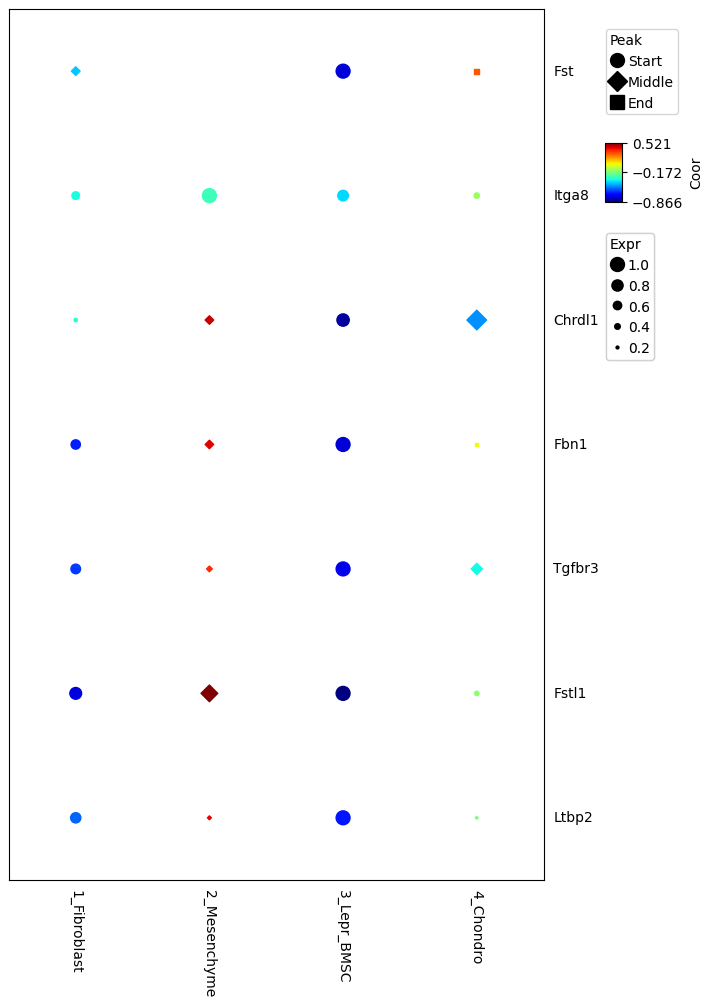

In [71]:
plt.figure(figsize=(7,10))
pch.DotClustermapPlotter(pathwayBMP,x='level_1',y='level_0',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,col_cluster=False,
                              show_rownames=True,show_colnames=True,spines=True)

In [73]:
pathwayTGF=makeLong("REACTOME_SIGNALING_BY_TGFB_FAMILY_MEMBERS",["GC_5","GC_6","GC_7"])

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


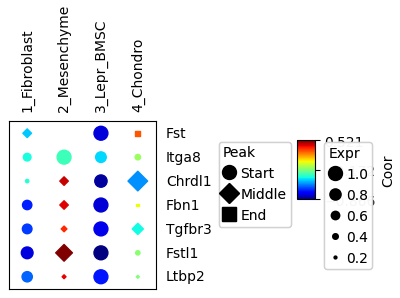

In [75]:
plt.figure(figsize=(2,2))
pch.DotClustermapPlotter(pathwayTGF,x='level_1',y='level_0',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,col_cluster=False,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_REACTOME_SIGNALING_BY_TGFB_FAMILY_MEMBERS.pdf")
plt.show()


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


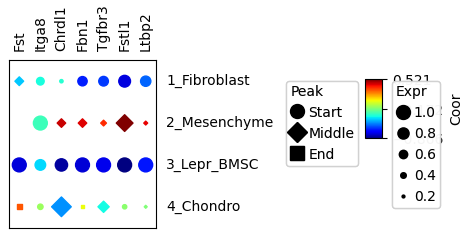

In [78]:
plt.figure(figsize=(2,2))
pch.DotClustermapPlotter(pathwayTGF,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_REACTOME_SIGNALING_BY_TGFB_FAMILY_MEMBERS.pdf")
plt.show()

In [81]:
pathwayActin=makeLong("REACTOME_SIGNALING_BY_ACTIVIN",["GC_5","GC_6","GC_7"])

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


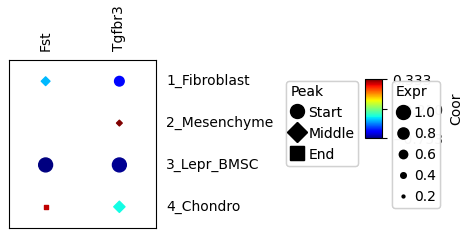

In [82]:
plt.figure(figsize=(2,2))
pch.DotClustermapPlotter(pathwayActin,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_Actin.pdf")
plt.show()

In [ ]:
set()

In [102]:
pathwayHEDGEHOG=makeLong("REACTOME_SIGNALING_BY_HEDGEHOG",["GC_8","GC_9"])

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

In [103]:
pathwayHEDGEHOG

,level_0,level_1,Coor,Expr,Peak
0,Tubb6,1_Fibroblast,-0.512089,0.949117,Middle
1,Tubb6,4_Chondro,-0.139513,0.936231,End
2,Tubb6,2_Mesenchyme,0.395031,1.000000,Middle
3,Tubb6,3_Lepr_BMSC,0.304072,0.676231,Middle
4,Tubb4b,1_Fibroblast,-0.440533,0.745088,Start
5,Tubb4b,4_Chondro,-0.275787,1.000000,End
6,Tubb4b,2_Mesenchyme,-0.598773,0.823346,Start
7,Tubb4b,3_Lepr_BMSC,0.179437,0.580004,Middle
8,Tuba1c,1_Fibroblast,-0.214414,0.493307,Middle
9,Tuba1c,4_Chondro,-0.247319,1.000000,End


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


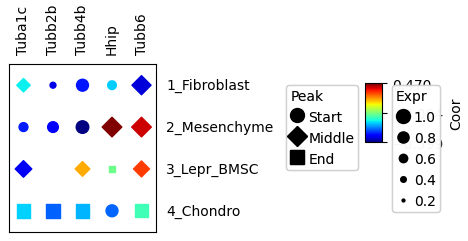

In [105]:
plt.figure(figsize=(2,2))
pch.DotClustermapPlotter(pathwayHEDGEHOG,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_pathwayHEDGEHOG.pdf")
plt.show()

In [117]:
pathwayWnt=makeLong("REACTOME_SIGNALING_BY_WNT",set(clusterGene["Unnamed: 2"]))

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


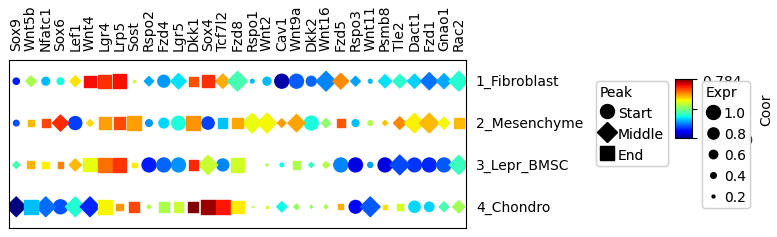

In [118]:
plt.figure(figsize=(6,2))
pch.DotClustermapPlotter(pathwayWnt,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_pathwayWnt.pdf")
plt.show()

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..


ValueError: The number of observations cannot be determined on an empty distance matrix.

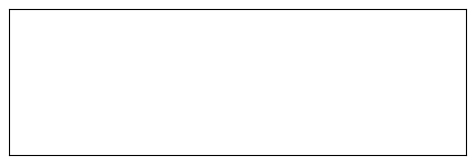

In [119]:
pathwayINTERLEUKIN2=makeLong("REACTOME_INTERLEUKIN_2_SIGNALING",["GC_5","GC_6","GC_7"])
plt.figure(figsize=(6,2))
pch.DotClustermapPlotter(pathwayINTERLEUKIN2,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_pathwayINTERLEUKIN2.pdf")
plt.show()

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


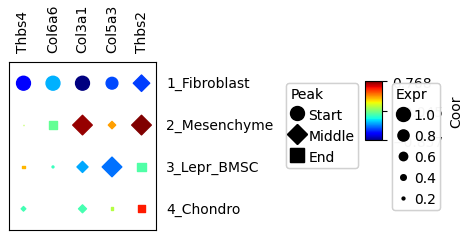

In [121]:
pathwayPDGF=makeLong("REACTOME_SIGNALING_BY_PDGF",["GC_3","GC_4","GC_5"])
plt.figure(figsize=(2,2))
pch.DotClustermapPlotter(pathwayPDGF,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_pathwayPDGF.pdf")
plt.show()

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


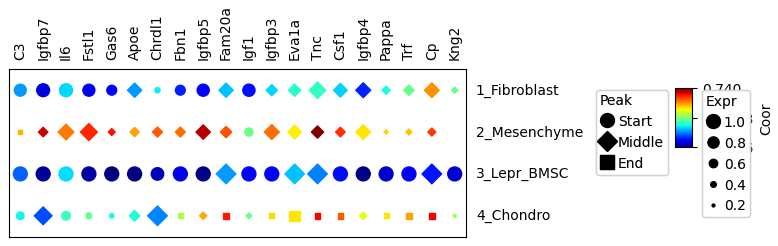

In [123]:
pathwayPDGF=makeLong("REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS",["GC_5","GC_6","GC_7"])
plt.figure(figsize=(6,2))
pch.DotClustermapPlotter(pathwayPDGF,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_IGF_IGFBP.pdf")
plt.show()

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


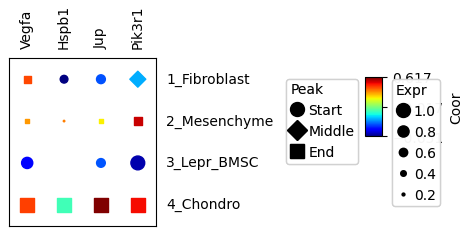

In [126]:
pathwaVEGF=makeLong("REACTOME_SIGNALING_BY_VEGF",["GC_1","GC_2"])
plt.figure(figsize=(2,2))
pch.DotClustermapPlotter(pathwaVEGF,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_VEGF.pdf")
plt.show()

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


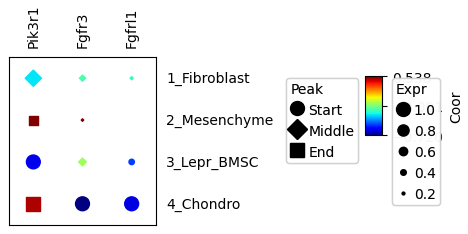

In [128]:
pathwayFGFR=makeLong("REACTOME_SIGNALING_BY_FGFR",["GC_1","GC_2"])
plt.figure(figsize=(2,2))
pch.DotClustermapPlotter(pathwayFGFR,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_pathwayFGFR.pdf")
plt.show()

In [98]:
m2GMT["genesymbol"][m2GMT["geneset"]=="REACTOME_WNT_MEDIATED_ACTIVATION_OF_DVL"]

187134     Csnk1e
187135    Csnk2a1
187136    Csnk2a2
187137     Csnk2b
187138       Dvl1
187139       Dvl2
187140       Dvl3
187141    Pip5k1b
Name: genesymbol, dtype: object

In [91]:
pathwayGROWTH_HORMONE=makeLong("REACTOME_GROWTH_HORMONE_RECEPTOR_SIGNALING",["GC_5","GC_6","GC_7"])

/tmp/ipykernel_3422810/504332109.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Fibroblast"]="1_Fibroblast"
/tmp/ipykernel_3422810/504332109.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level_1"]=="Mesenchyme"]="2_Mesenchyme"
/tmp/ipykernel_3422810/504332109.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combineDf["level_1"][combineDf["level

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


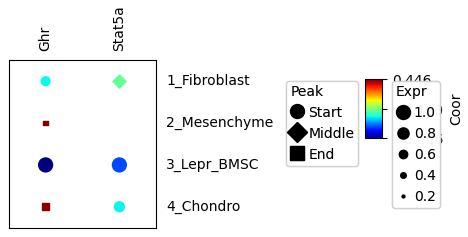

In [92]:
plt.figure(figsize=(2,2))
pch.DotClustermapPlotter(pathwayGROWTH_HORMONE,x='level_0',y='level_1',value='Coor',c='Coor',hue='Peak',s="Expr",
                              marker={'Start':'o','Middle':'D','End':'s'},row_dendrogram=False,ratio=100,
                              show_rownames=True,show_colnames=True,
                         spines=True,row_cluster=False,col_cluster=True,col_names_side="top")
plt.savefig("../result/24.2.4_fig3_pathway//dotplot_pathwayGROWTH_HORMONE.pdf")
plt.show()

In [28]:
notchPathway=makeLong(intersection_genes)

In [129]:
dpt=sc.read("../../important_processed_data/11.16_dpt.h5ad")

In [130]:
dpt

AnnData object with n_obs × n_vars = 166204 × 17312
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'le

In [135]:
lineageDpt=dpt.obs[[ 'lineage_chondro', 'lineage_laFibro', 'lineage_lepr', 'lineage_mesenchyme']]

In [151]:
np.array(lineageDpt)*1


array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 0]])

In [166]:
crLineage=cr._utils.Lineage(np.array(lineageDpt)*dpt.obs[['pred_dpt']].values,
                            names=[ 'Chondro-OPCST', 'Fibro-OPCST', 'Lepr_BMSC-OPCST', 'Mesenchyme-OPCST'],
                            colors=["#3C5488B2", "#4DBBD5B2","#F39B7FB2","#00A087B2"])

In [167]:
crLineage

Chondro-OPCST,Fibro-OPCST,Lepr_BMSC-OPCST,Mesenchyme-OPCST
0.000000,0.000000,0.000000,0.605699
0.000000,0.000000,0.000000,0.556272
0.000000,0.000000,0.000000,0.608749
0.000000,0.000000,0.000000,0.650236
0.000000,0.000000,0.000000,0.635134
0.000000,0.000000,0.000000,0.300004
0.000000,0.000000,0.000000,0.601009
0.000000,0.000000,0.000000,0.569059
0.000000,0.000000,0.000000,0.508324
0.000000,0.000000,0.000000,0.606008


In [168]:
dpt.obsm["to_terminal_states"]=crLineage

  0%|          | 0/1 [00:00<?, ?gene/s]

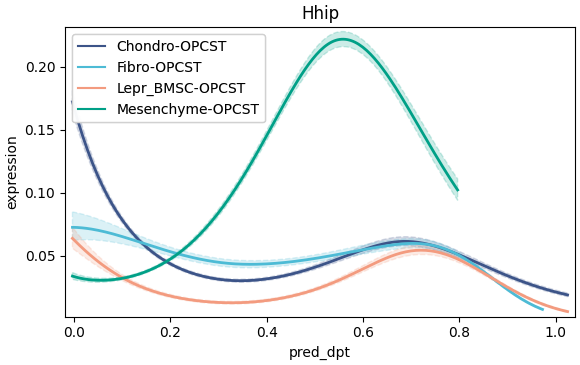

In [171]:
model = cr.models.GAM(dpt)
cr.pl.gene_trends(
    dpt,
    model=model,
    data_key="X",
    genes=["Hhip"],
    ncols=3,
    time_key="pred_dpt",
    same_plot=True,
    hide_cells=True,
    figsize=(6, 4),
    n_test_points=200,n_jobs=-1,save="Hhip_tissue.pdf"
)


In [1]:
dpt

NameError: name 'dpt' is not defined